In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python '/content/drive/MyDrive/Projects/sparse_learning-d0-wideresnet502/mnist_cifar/main.py' --data cifar --model wrn-28-2

Namespace(batch_size=100, bench=False, data='cifar', decay_frequency=25000, decay_schedule='cosine', dense=False, density=0.05, epochs=100, fp16=False, growth='momentum', iters=1, l1=0.0, l2=0.0005, log_interval=100, lr=0.1, max_threads=10, model='wrn-28-2', momentum=0.9, no_cuda=False, optimizer='sgd', prune='magnitude', prune_rate=0.5, redistribution='momentum', resume=None, save_features=False, save_model='./models/model.pt', seed=17, start_epoch=1, test_batch_size=100, valid_split=0.1, verbose=False)




Iteration start: 1/1

Image path example:  /content/drive/MyDrive/AI/Datasets/D0/24/DSC_4004.jpg
Class example:  9
Train size: 3155
Valid size: 947
Test size: 406
The shape of tensor for 50th image in train dataset:  torch.Size([3, 256, 256])
The label for 50th image in train dataset:  10
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated si

In [ ]:
train_model_training_loss_ls = []
train_model_training_accuracy_ls = []
validation_model_training_loss_ls = []
validation_model_training_accuracy_ls = [] 
with open("/content/drive/MyDrive/Projects/sparse_learning-d0-resnet50/train_model_training_loss_ls.txt", "r") as f:
  for line in f:
    train_model_training_loss_ls.append((float)(line.strip()))
with open("/content/drive/MyDrive/Projects/sparse_learning-d0-resnet50/train_model_training_accuracy_ls.txt", "r") as f:
  for line in f:
    train_model_training_accuracy_ls.append((float)(line.strip()))
with open("/content/drive/MyDrive/Projects/sparse_learning-d0-resnet50/validation_model_training_loss_ls.txt", "r") as f:
  for line in f:
    validation_model_training_loss_ls.append((float)(line.strip()))
with open("/content/drive/MyDrive/Projects/sparse_learning-d0-resnet50/validation_model_training_accuracy_ls.txt", "r") as f:
  for line in f:
    validation_model_training_accuracy_ls.append((float)(line.strip()))



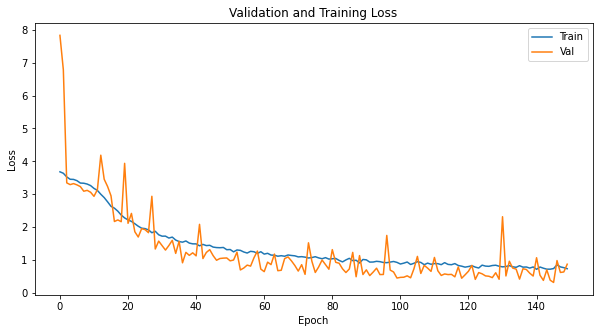

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Validation and Training Loss")
plt.plot(train_model_training_loss_ls,label="Train")
plt.plot(validation_model_training_loss_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

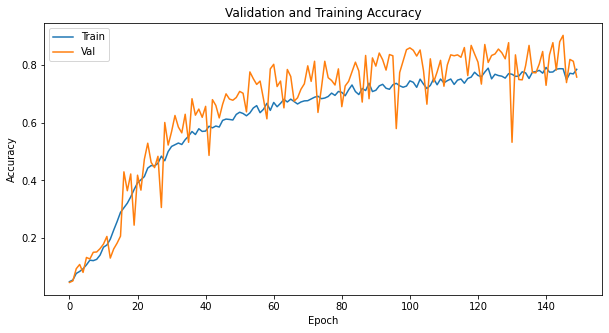

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Accuracy")
plt.plot(train_model_training_accuracy_ls,label="Train")
plt.plot(validation_model_training_accuracy_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
import torchvision
import torch.nn.functional as F
from torch import optim
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=224, width=224),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

data_path = '/content/drive/MyDrive/AI/Datasets/D0' 

image_paths = [] 
classes = [] 

for data_path in glob.glob(data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    image_paths.append(glob.glob(data_path + '/*'))
    
image_paths = list(flatten(image_paths))
random.shuffle(image_paths)

train_image_paths, valid_test_image_paths = image_paths[:int(0.7*len(image_paths))], image_paths[int(0.7*len(image_paths)):]
valid_image_paths, test_image_paths = valid_test_image_paths[:int(0.7*len(valid_test_image_paths))], valid_test_image_paths[int(0.7*len(valid_test_image_paths)):]

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

class D0Dataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label
    
train_dataset = D0Dataset(train_image_paths,train_transforms)
valid_dataset = D0Dataset(valid_image_paths,test_transforms)
test_dataset = D0Dataset(test_image_paths,test_transforms)


train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

In [ ]:
PATH = '/content/drive/MyDrive/AI/V2_ResNet_D0_Sparse_Learning'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 40),nn.LogSoftmax(dim=1)
)
model.load_state_dict(torch.load(PATH))
model = model.to(device)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the total test images: {100 * correct // total} %')


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Accuracy of the network on the total test images: 72 %
